# Generating potential Citi Bike stations locations in Borough Park

This notebook generated potential Citi Bike station locations in Borough Park, Brooklyn, US (or other areas within this UTM zone) based on the network graph, created using the *OSMNX library*. It creates a network and a bigger version of it, then buffers all nodes of the network and generates 5 random points (potential locations) that are both within the buffer and lie on the graph. The only inputs required are the input file (area boundrary), distance to buffer the initial polygon, and distance of node buffer.

**Code to start the workflow is at the bottom.** 

# Functions

In [38]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import osmnx as ox
import networkx as nx
from pyproj import Proj, transform

from shapely.geometry import shape, Point, Polygon, LineString, MultiLineString
from shapely.ops import unary_union

import random

In [39]:
def generate_random_points_on_linestring(index, linestring, num_points, min_distance, max_attempts):
    total_length = linestring.length
    random_points = []

    for _ in range(max_attempts):
        random_distances = np.sort(np.random.uniform(0, total_length, num_points))
        candidate_points = [linestring.interpolate(distance) for distance in random_distances]

        # Check if points satisfy the minimum distance criterion
        if all(linestring.project(candidate_points[i]) - linestring.project(candidate_points[i-1]) > min_distance
               for i in range(1, len(candidate_points))):
            return gpd.GeoDataFrame({'original_index': [index]*num_points, 'geometry': candidate_points})

    raise ValueError(f"Could not find a set of points satisfying the minimum distance criterion within the given number of attempts for index {index}.")


In [40]:
def create_potential_location(input_path, polygon_buffer_dist, buffer_dist):

    # Read the shapefile into a GeoDataFrame
    gdf = gpd.read_file(input_path)

    # Transform the CRS to EPSG 4326 (WGS84)
    gdf_wgs84 = gdf.to_crs(epsg=4326)

    # Print the transformed CRS
    print(f"Polygon transformed from {gdf.crs} to {gdf_wgs84.crs}")

    # CREATING ROAD NETWORK

    graph = ox.graph.graph_from_polygon(
        gdf_wgs84.iloc[0].geometry,
        network_type="drive",
        retain_all = True
    )

    place_polygon = gdf_wgs84

    # Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
    place_polygon = place_polygon.to_crs("EPSG:32618")

    # Buffer by X meters
    place_polygon["geometry"] = place_polygon.buffer(polygon_buffer_dist)

    # Re-project the polygon back to WGS84 (required by OSMnx)
    place_polygon = place_polygon.to_crs("EPSG:4326")

    graph_buffed = ox.graph_from_polygon(
        place_polygon.at[0, "geometry"],
        network_type="drive",
        retain_all = True
    )

    graph_consolidated = ox.consolidate_intersections(
        ox.project_graph(graph_buffed),
        tolerance=30,
        rebuild_graph = True, 
        reconnect_edges = True)

    # Convert nodes to GeoDataFrame with a UTM CRS
    gdf_nodes = gpd.GeoDataFrame(geometry=[Point(data['x'], data['y']) for _, 
                                           data in graph_consolidated.nodes(data=True)])
    gdf_nodes.crs = "EPSG:32618"

    buffer_distance_meters = buffer_dist  
    buffers = gdf_nodes.buffer(buffer_distance_meters)

    # PLOTTING NETWORKS 

    fig, axs = plt.subplots(3, 2, figsize=(18, 18))

    gdf_wgs84.plot(color = 'grey', ax=axs[0, 0])
    axs[0, 0].set_title('Initial polygon', loc='left')


    ox.plot_graph(ox.project_graph(graph), ax=axs[0, 1], show=False, close=False,
                  bgcolor='white',
                  node_color='black',  
                  edge_color='grey',  
                  node_size=13,
                  edge_linewidth=0.8)

    axs[0, 1].set_title('Road network', loc='left' )

    ox.plot_graph(ox.project_graph(graph_buffed), ax=axs[1, 0], show=False, close=False,
                  bgcolor='white',
                  node_color='black',  
                  edge_color='grey',  
                  node_size=15,
                  edge_linewidth=0.8)

    axs[1, 0].set_title('Road network from buffed polygon', loc='left' )

    ox.plot_graph(ox.project_graph(graph_consolidated), ax=axs[1, 1], show=False, close=False,
                  bgcolor='white',
                  node_color='black',  
                  edge_color='grey',  
                  node_size=13,
                  edge_linewidth=0.8)

    axs[1, 1].set_title('Road network with simplified nodes', loc='left' )

    fig, ax = ox.plot_graph(ox.project_graph(graph_consolidated), ax=axs[2, 0], show=False, close=False,
                           bgcolor='white',
        node_color='black',
        edge_color='grey',
        node_size=13,
        edge_linewidth=0.8,)

    buffers.plot(ax=axs[2, 0], color='blue', alpha=0.2)
    axs[2, 0].set_title('Road network with buffed nodes', loc='left' )

    fig.delaxes(axs[2, 1])

    graph = graph_consolidated
    buffers = buffers.to_crs(graph.graph['crs'])

    if not graph.graph['crs'] == buffers.geometry.crs:
        raise ValueError

    graph = ox.project_graph(graph, to_crs="EPSG:32618")

    # Get GeoDataFrames of nodes and edges from the graph
    nodes, edges = ox.graph_to_gdfs(graph)

    # Extract LineString geometries from the 'geometry' column of the 'edges' GeoDataFrame
    line_geometries = edges['geometry']

    # Create a GeoDataFrame of LineString geometries
    lines_gdf = gpd.GeoDataFrame(geometry=line_geometries, crs=edges.crs)

    buffers_gdf = gpd.GeoDataFrame(geometry=buffers, crs=buffers.crs)

    joined = gpd.sjoin(lines_gdf, buffers_gdf, predicate='intersects')

    if not joined.geometry.crs == buffers.geometry.crs:
        raise ValueError

    grouped_gdf = joined.groupby('index_right')['geometry'].apply(unary_union).reset_index()

    # Create a new GeoDataFrame with the aggregated geometries
    aggregated_gdf = gpd.GeoDataFrame(grouped_gdf, geometry='geometry', crs="EPSG:32618")

    if not aggregated_gdf.geometry.crs == buffers.geometry.crs:
        raise ValueError

    # Empty GeoDataFrame to store the results
    columns = ['original_index', 'geometry']
    result_gdf = gpd.GeoDataFrame(columns=columns)

    for index, row in aggregated_gdf.iterrows():
        linestring = row['geometry']
        points_df = generate_random_points_on_linestring(index, linestring, num_points=5, min_distance=25, 
                                                         max_attempts = 10000000)
        result_gdf = pd.concat([result_gdf, points_df], ignore_index=True)

    result_gdf.crs = "epsg:32618"

    if not result_gdf.geometry.crs == buffers.geometry.crs:
        raise ValueError
        
    print(f"CRS of the outuput: {result_gdf.crs}")
    
    return result_gdf, fig, axs


# Generate output

In [41]:
# Define input and output paths

input_file = 'project2.gpkg'

output_file = "possible_locations.gpkg"

In [42]:
# Define buffers used

polygon_buffer_dist = 300
buffer_dist = 75

Polygon transformed from EPSG:32618 to EPSG:4326
CRS of the outuput: epsg:32618


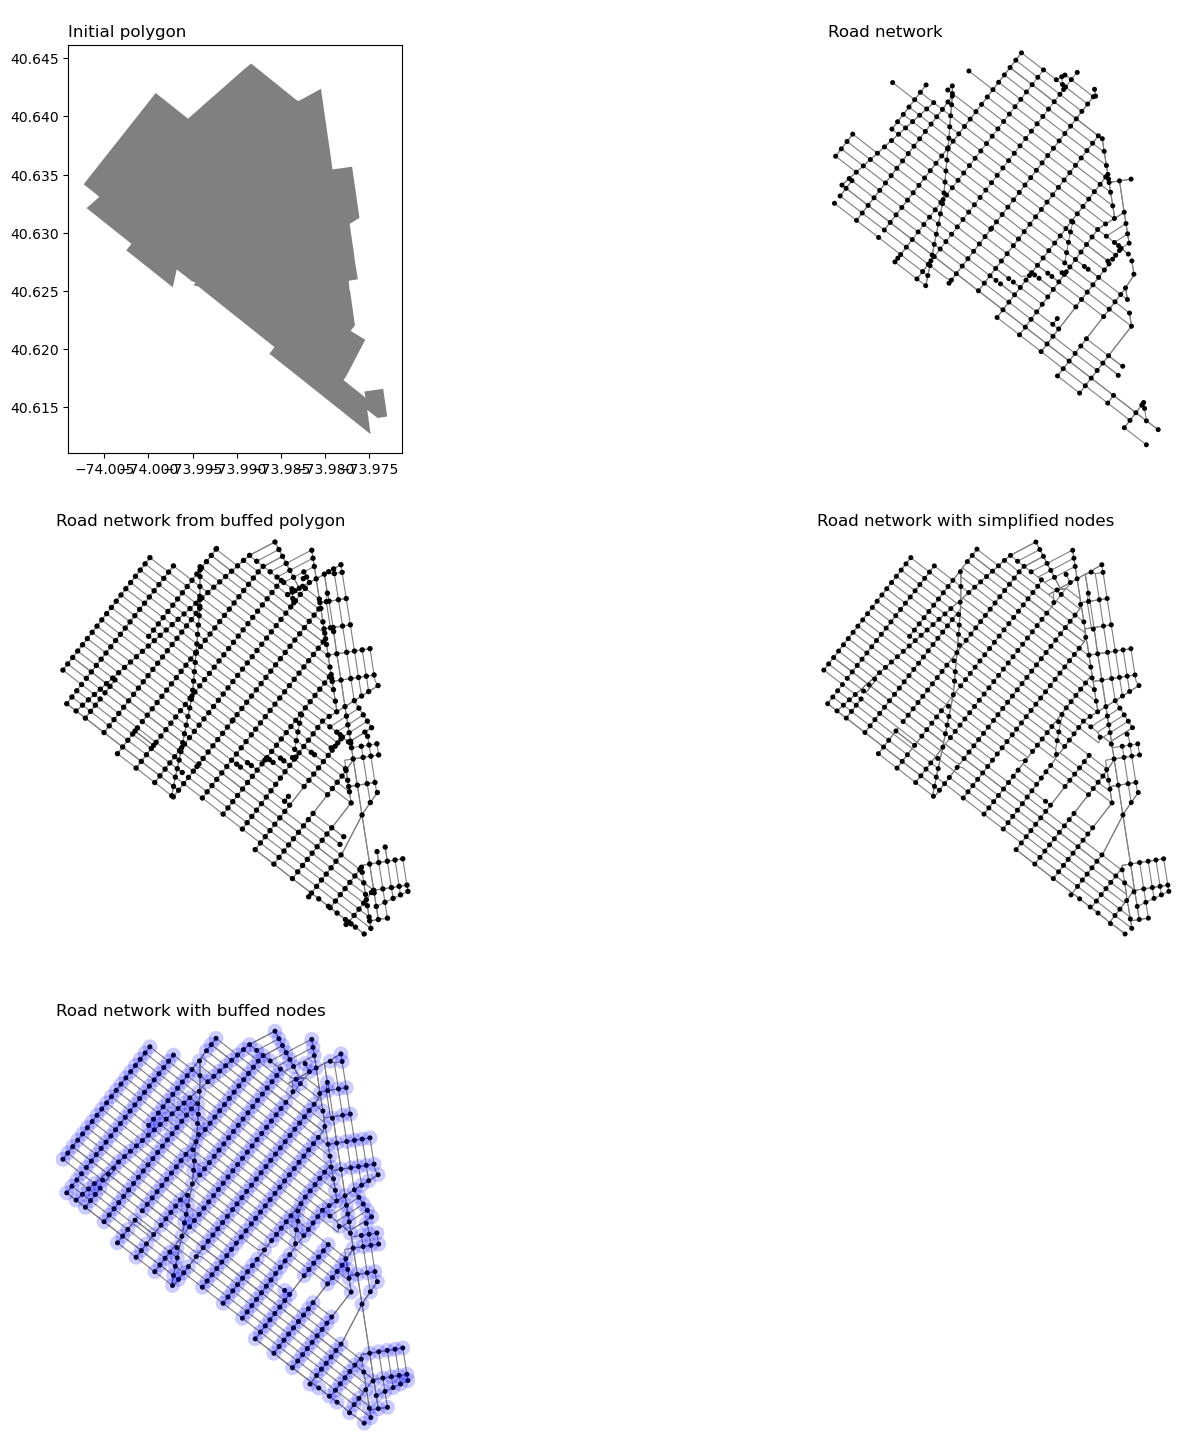

In [43]:
result, fig, axs = create_potential_location(input_file, polygon_buffer_dist, buffer_dist)

In [44]:
# Final cell to generate the output file
result.to_file(output_file, driver="GPKG", 
                   layer='possible_locations_points', crs = "EPSG:32618")